1. Import and Understand the data 

In [ ]:
import os
import cv2
import keras
import pandas             as pd
import matplotlib.pyplot  as plt
import matplotlib.patches as patches

import numpy              as np
import tensorflow         as tf
import pickle
import os
from glob import glob



from zipfile import ZipFile
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


'2.9.2'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


A. Import and read ‘images.npy’

In [ ]:
print(os.listdir("../content"))

['.config', 'drive', 'sample_data']


In [ ]:
data = np.load('/content/drive/MyDrive/data/CV2/images.npy', allow_pickle = True)
data.shape

(409, 2)

In [ ]:
type(data)

numpy.ndarray

In [ ]:
images = data[:,0]
mask = data[:,1]
print("Image Shape",images.shape)
print("Mask Shape",mask.shape)

Image Shape (409,)
Mask Shape (409,)


In [ ]:
type(mask)

numpy.ndarray

In [ ]:
plt.imshow(images[275])

In [ ]:
display(mask[275] )


[{'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.40082644628099173, 'y': 0.13488372093023257},
   {'x': 0.5113636363636364, 'y': 0.32558139534883723}],
  'imageWidth': 1024,
  'imageHeight': 683}]

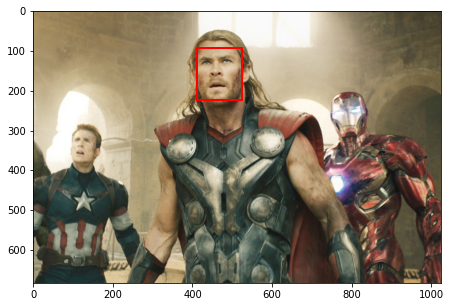

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10, 5))
ax.imshow(data[275][0])
for lbl in data[275][1]:
    rect = patches.Rectangle((lbl['points'][0]['x']*lbl['imageWidth'], lbl['points'][0]['y']*lbl['imageHeight']), lbl['points'][1]['x']*lbl['imageWidth'] - lbl['points'][0]['x']*lbl['imageWidth'], lbl['points'][1]['y']*lbl['imageHeight']- lbl['points'][0]['y']*lbl['imageHeight'], linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)


B. Split the data into Features(X) & labels(Y). Unify shape of all the images.

Here feature is the image
The label is the mask
Images will be stored in "X" array
Masks will be stored in "masks" array

1.   List item
2.   List item



Unify shape of images to 224

In [ ]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
ALPHA = 1

In [ ]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

In [ ]:
print("X Shape",X.shape)
print("mask Shape",masks.shape)

X Shape (409, 224, 224, 3)
mask Shape (409, 224, 224)


*C*. Split the data into train and test[400:9]. 

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, masks,train_size=400 ,test_size=9)

In [ ]:
print("X Train Shape",X_train.shape)
print("X Test Shape",X_test.shape)
print("Y Train Shape",y_train.shape)
print("Y Test Shape",y_test.shape)

X Train Shape (400, 224, 224, 3)
X Test Shape (9, 224, 224, 3)
Y Train Shape (400, 224, 224)
Y Test Shape (9, 224, 224)



D. Select random image from the train data and display original image and masked image

Orginal Image

In [ ]:
from matplotlib import pyplot
n = 75
pyplot.imshow(X_train[n])

Masked Image

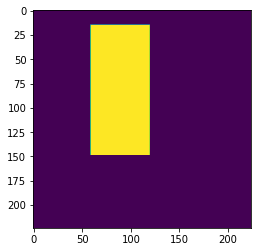

In [ ]:
pyplot.imshow(masks[n])

2. Model building 

Add MobileNet as model with below parameter values
input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
include_top: False
alpha: 1.0
weights: "imagenet"
Add UNET architecture layers
This is the trickiest part of the project, you need to research and implement it correctly

In [ ]:
model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=ALPHA, weights="imagenet")
model.summary()


Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.models import Model


def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=ALPHA, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable

    block1 = model.get_layer("conv_pw_5_relu").output
    block2 = model.get_layer("conv_pw_11_relu").output
    block3 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block3), block2])
    x = Concatenate()([UpSampling2D()(x), block1])

    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((28, 28))(x)

    return Model(inputs=model.input, outputs=x)
    

In [ ]:
# Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)
ALPHA=1

model = create_model()

# Print summary
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 112, 112, 32  128         ['conv1[0][0]']                  
                                )                                                           

B. Design your own Dice Coefficient and Loss function.

In [ ]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

In [ ]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

In [ ]:
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model = create_model(False)
model.summary()
optimizer = tf.keras.optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer = optimizer, metrics=[dice_coefficient])

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 112, 112, 32  128         ['conv1[0][0]']                  
                                )                                                           

C. Train and tune the model as required.

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", period=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

In [ ]:
masks_resize= np.zeros((int(y_train.shape[0]), 28,28))
for index in range(y_train.shape[0]):
  masks_resize[index]= cv2.resize(y_train[index], dsize=(28,28), interpolation=cv2.INTER_CUBIC)

In [ ]:
masks_resize.shape

(400, 28, 28)

In [ ]:
model.fit(X_train,masks_resize,batch_size=1, callbacks=[checkpoint, reduce_lr, stop],verbose=1,epochs=40)

Epoch 1/40
393/400 [============================>.] - ETA: 0s - loss: 1.9626 - dice_coefficient: 0.2821
Epoch 1: loss improved from inf to 1.94962, saving model to model-1.95.h5
400/400 [==============================] - 4s 6ms/step - loss: 1.9496 - dice_coefficient: 0.2851 - lr: 1.0000e-04
Epoch 2/40
396/400 [============================>.] - ETA: 0s - loss: 1.2678 - dice_coefficient: 0.4233
Epoch 2: loss improved from 1.94962 to 1.26699, saving model to model-1.27.h5
400/400 [==============================] - 3s 7ms/step - loss: 1.2670 - dice_coefficient: 0.4230 - lr: 1.0000e-04
Epoch 3/40
396/400 [============================>.] - ETA: 0s - loss: 1.0859 - dice_coefficient: 0.4823
Epoch 3: loss improved from 1.26699 to 1.08530, saving model to model-1.09.h5
400/400 [==============================] - 3s 8ms/step - loss: 1.0853 - dice_coefficient: 0.4827 - lr: 1.0000e-04
Epoch 4/40
393/400 [============================>.] - ETA: 0s - loss: 1.0005 - dice_coefficient: 0.5160
Epoch 4: los

D. Evaluate and share insights on performance of the model. [2 Marks]

3. Test the model predictions on the test image: ‘image with index 3 in the test data’ and visualise the predicted masks on the faces in the image. [2 Marks]

In [ ]:
test_image = X_test[1]


In [ ]:
masks_resize= np.zeros((int(y_test.shape[0]), 28,28))
for index in range(y_test.shape[0]):
  masks_resize[index]= cv2.resize(y_test[index], dsize=(28,28), interpolation=cv2.INTER_CUBIC)

In [ ]:
plt.imshow(test_image)

In [ ]:
img_pred =img_pred.reshape(28,28)


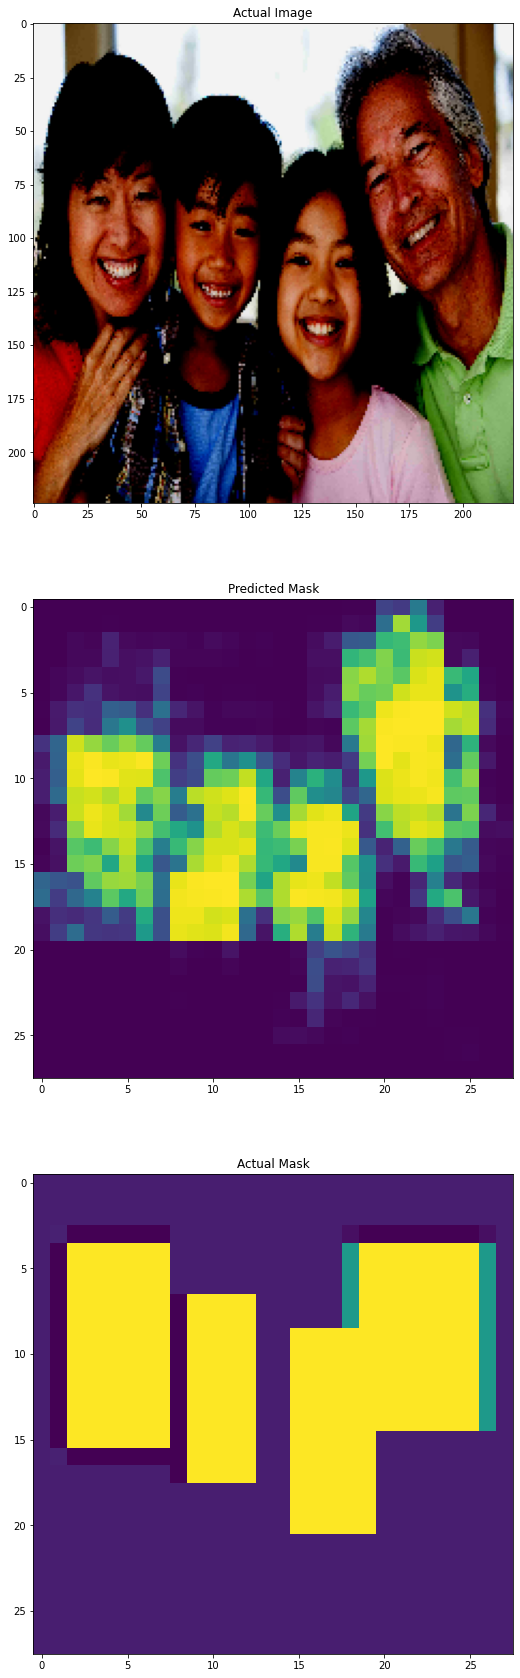

In [ ]:

pyplot.figure(figsize=(20,30))
pyplot.subplot(3,1,1)
pyplot.gca().set_title('Actual Image')
pyplot.imshow(test_image)
pyplot.subplot(3,1,2)
pyplot.gca().set_title('Predicted Mask')
pyplot.imshow(img_pred.reshape(28,28))
pyplot.subplot(3,1,3)
pyplot.gca().set_title('Actual Mask')
pyplot.imshow(masks_resize[1])

PART B

1.Read/import images from folder ‘training_images’.

In [ ]:
extract_path='/content/drive/MyDrive/data/CV2/'

In [ ]:
images_zip_path = '/content/drive/MyDrive/data/CV2/training_images-20211126T092819Z-001.zip'
from zipfile import ZipFile

with ZipFile(images_zip_path, 'r') as z:
  z.extractall(extract_path)

2. Write a loop which will iterate through all the images in the ‘training_images’ folder and detect the faces present on all the images. 

In [ ]:
imgae_path =extract_path +"training_images/*.jpg"

files = glob(imgae_path)

In [ ]:
from google.colab.patches import cv2_imshow
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades +'haarcascade_eye.xml')



In [ ]:
df = pd.DataFrame(columns=['x','y','w','h','Total_Faces','Image_Name']) 


In [ ]:
df.head(5)

Empty DataFrame
Columns: [x, y, w, h, Total_Faces, Image_Name]
Index: []

In [ ]:
cv_img = []
trainLabel = []

for img in files:
  img = cv2.imread(img) 
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  faces = face_cascade.detectMultiScale(gray, 1.3, 5)
  print(faces)
  

()
()
[[ 52 143 389 389]]
[[ 65 119 430 430]]
[[ 63  51 484 484]]
()
[[114 157 389 389]]
[[163 155 388 388]]
[[139 122 410 410]]
()
()
[[163 169 361 361]]
[[110 105 400 400]]
[[ 77  87 467 467]]
[[ 76 103 430 430]]
[[104 170 368 368]]
[[ 31 154 368 368]]
[[ 85 115 412 412]]
[[106 165 408 408]]
[[114  85 442 442]]
()
()
()
()
()
[[116 169 388 388]]
[[167 178 372 372]]
()
()
[[125 154 365 365]]
[[ 87  53 433 433]]
[[ 71 106 456 456]]
()
[[131 162 378 378]]
[[121 185 365 365]]
[[ 82 146 430 430]]
[[ 39  66 494 494]]
[[ 86 162 405 405]]
()
[[ 37  41 460 460]]
[[112 187 390 390]]
()
()
[[149 171 370 370]]
[[ 49  84 452 452]]
()
()
()
[[134 116 430 430]]
[[ 48 111 442 442]]
[[ 97 159 384 384]]
[[ 85  92 444 444]]
[[ 65  63 478 478]]
[[152 210 354 354]]
()
()
[[ 28 149 430 430]]
()
[[ 88 175 378 378]]
[[ 71 138 430 430]]


KeyboardInterrupt: ignored

In [ ]:
img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
faces = face_cascade.detectMultiScale(img,scaleFactor=1.1, minNeighbors=4)
print(faces)
#returns a list of (x,y,w,h) tuples
img_2 = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #converted to colored o/p image
for (x,y,w,h) in faces:
    cv2.rectangle(img_2,(x,y),(x+w,y+h),(0,0,250),2)
    
plt.figure(figsize=(12,12))
plt.imshow(img_2)

In [ ]:
img=images[275]

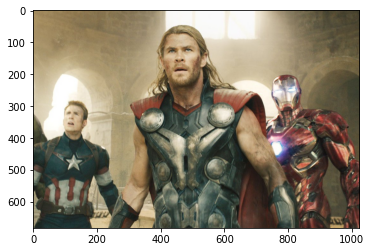

In [ ]:
plt.imshow(img)

In [ ]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades +'haarcascade_eye.xml')


[[ 73 149 398 398]]


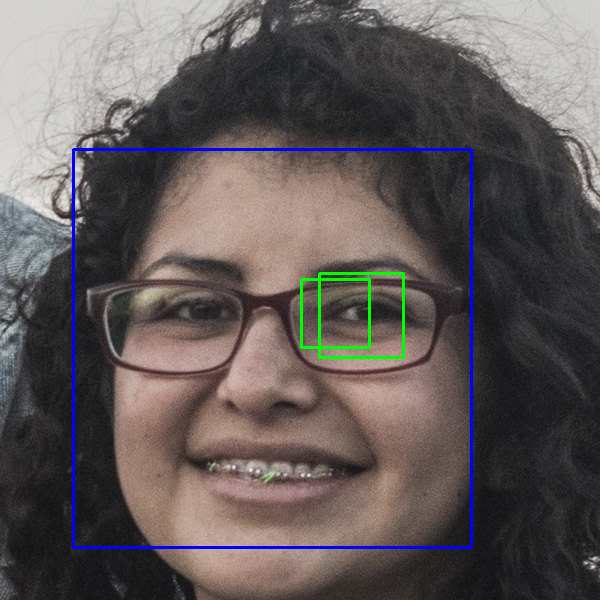

In [ ]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
print(faces)
for (x,y,w,h) in faces:
    img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)

cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()

[[ 69 138 417 417]]


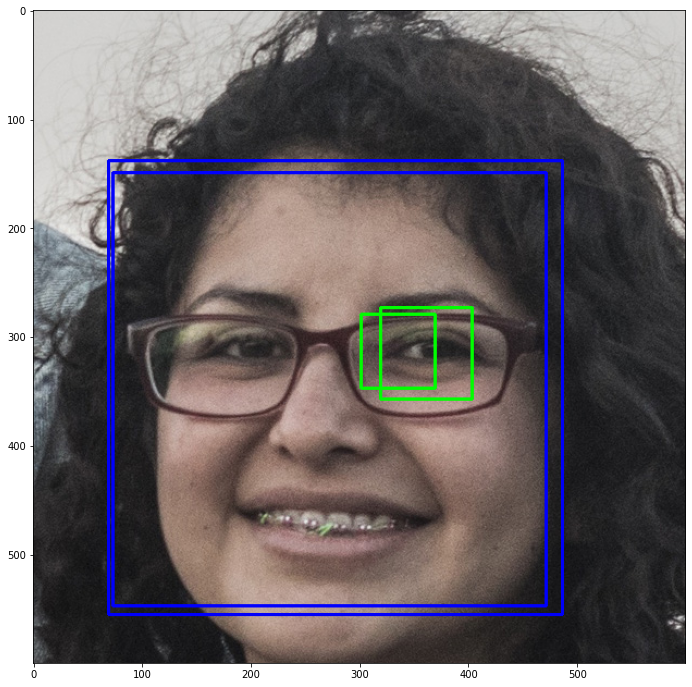

In [ ]:
img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
faces = face_cascade.detectMultiScale(img,scaleFactor=1.1, minNeighbors=4)
print(faces)
#returns a list of (x,y,w,h) tuples
img_2 = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #converted to colored o/p image
for (x,y,w,h) in faces:
    cv2.rectangle(img_2,(x,y),(x+w,y+h),(0,0,250),2)
    
plt.figure(figsize=(12,12))
plt.imshow(img_2)

In [ ]:
df = pd.DataFrame(columns=['x','y','w','h','Total_Faces','Image_Name']) 
